In [8]:
# 参考： 
# https://jkjung-avt.github.io/keras-tutorial/
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [1]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess)

## 引用包和常量定义

In [23]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.inception_v3 import *
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import shutil
import random
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

DIR_TRAIN = './data/train'
DIR_REVIEW = './data/review'
DIR_TRAIN_NEW = './data/train_new'
DIR_TRAIN_NEW_DOG = './data/train_new/dogs'
DIR_TRAIN_NEW_CAT = './data/train_new/cats'
DIR_VALID_NEW = './data/valid'
DIR_VALID_NEW_DOG = './data/valid/dogs'
DIR_VALID_NEW_CAT = './data/valid/cats'

IMAGE_SIZE    = (299, 299)
IMAGE_SIZE_1  = (299, 299, 3)
NUM_CLASSES   = 2
BATCH_SIZE    = 64  
FREEZE_LAYERS = 2  
NUM_EPOCHS    = 10
WEIGHTS_FINAL = 'model-InceptionV3-final-no-aug.h5'

## 数据准备

剔除异常图片的训练集和目录结构以及在数据处理过程中准备好了。需要从准备好的训练集中抽出20%的图片作为验证集放到DIR_VALID_NEW。

In [7]:
if not os.path.exists(DIR_VALID_NEW):
    os.mkdir(DIR_VALID_NEW)
if not os.path.exists(DIR_VALID_NEW_DOG):
    os.mkdir(DIR_VALID_NEW_DOG)
if not os.path.exists(DIR_VALID_NEW_CAT):
    os.mkdir(DIR_VALID_NEW_CAT)

if not os.path.exists(DIR_TRAIN_NEW):
    os.mkdir(DIR_TRAIN_NEW)
if not os.path.exists(DIR_TRAIN_NEW_CAT):
    os.mkdir(DIR_TRAIN_NEW_CAT)
if not os.path.exists(DIR_TRAIN_NEW_DOG):
    os.mkdir(DIR_TRAIN_NEW_DOG)

In [5]:
files = os.listdir(DIR_TRAIN)
cats = [img for img in filter(lambda x:x[:3] == 'cat', files)]
dogs = [img for img in filter(lambda x:x[:3] == 'dog', files)]

reviewFiles = os.listdir(DIR_REVIEW)

for f in tqdm(cats):
    if f not in reviewFiles:
        src = os.path.join(DIR_TRAIN, f)
        shutil.copy(src, DIR_TRAIN_NEW_CAT)
        
for f in tqdm(dogs):
    if f not in reviewFiles:
        src = os.path.join(DIR_TRAIN, f)
        shutil.copy(src, DIR_TRAIN_NEW_DOG)

100%|██████████| 12500/12500 [00:01<00:00, 9557.00it/s]


In [6]:
cat_files = [img for img in filter(lambda x:x[:3] == 'cat', os.listdir(DIR_TRAIN_NEW_CAT))]
dog_files = [img for img in filter(lambda x:x[:3] == 'dog', os.listdir(DIR_TRAIN_NEW_DOG))]
print(len(cat_files)) # 20% 约等于 2450 个
print(len(dog_files))

12477
12480


In [8]:
# 因为图片内容本身是无序的，所以可以直接分别把训练集里dogs和cats中的2450个图片放到验证集里。
def mv_valid_images(files, src_dir, target_dir):
    index = 1
    for f in tqdm(files):
        if index > 2450:
            return
        src = os.path.join(src_dir, f)
        target = os.path.join(target_dir, f)
        shutil.move(src, target)
    
        index = index + 1

In [9]:
# cats
mv_valid_images(cat_files, DIR_TRAIN_NEW_CAT, DIR_VALID_NEW_CAT)

  0%|          | 0/12477 [00:00<?, ?it/s]


In [10]:
# dogs
mv_valid_images(dog_files, DIR_TRAIN_NEW_DOG, DIR_VALID_NEW_DOG)

  0%|          | 0/12480 [00:00<?, ?it/s]


In [28]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_batches = train_datagen.flow_from_directory(DIR_TRAIN_NEW,
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(DIR_VALID_NEW,
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

Found 20057 images belonging to 2 classes.
Found 4900 images belonging to 2 classes.
****************
Class #0 = cats
Class #1 = dogs
****************


In [29]:
net = InceptionV3(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=IMAGE_SIZE_1)
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 149, 149, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 149, 149, 32) 0           batch_normalization_376[0][0]    
__________________________________________________________________________________________________
conv2d_377

In [30]:
# train the model
train_steps=train_batches.samples // BATCH_SIZE
valid_steps=valid_batches.samples // BATCH_SIZE
train_history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_steps,
                        validation_data = valid_batches,
                        validation_steps = valid_steps,
                        epochs = NUM_EPOCHS)

# save trained weights
net_final.save(WEIGHTS_FINAL)

Epoch 1/10
313/313 [==============================] - 730s 2s/step - loss: 0.1458 - acc: 0.9411 - val_loss: 0.0374 - val_acc: 0.9883
Epoch 2/10
313/313 [==============================] - 684s 2s/step - loss: 0.0268 - acc: 0.9905 - val_loss: 0.0304 - val_acc: 0.9897
Epoch 3/10
313/313 [==============================] - 686s 2s/step - loss: 0.0113 - acc: 0.9968 - val_loss: 0.0288 - val_acc: 0.9926
Epoch 4/10
313/313 [==============================] - 683s 2s/step - loss: 0.0061 - acc: 0.9979 - val_loss: 0.0284 - val_acc: 0.9934
Epoch 5/10
313/313 [==============================] - 683s 2s/step - loss: 0.0039 - acc: 0.9989 - val_loss: 0.0313 - val_acc: 0.9920
Epoch 6/10
313/313 [==============================] - 684s 2s/step - loss: 0.0030 - acc: 0.9991 - val_loss: 0.0276 - val_acc: 0.9934
Epoch 7/10
313/313 [==============================] - 683s 2s/step - loss: 0.0025 - acc: 0.9992 - val_loss: 0.0284 - val_acc: 0.9932
Epoch 8/10
313/313 [==============================] - 683s 2s/step - 

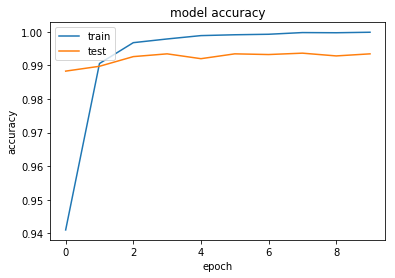

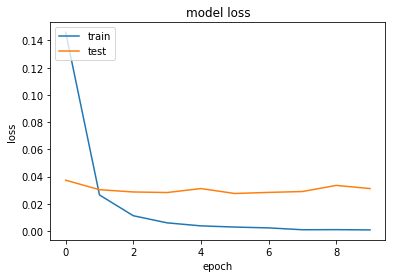

In [31]:
def plot_training(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
  
plot_training(train_history)

In [13]:
tmp = os.listdir('./data/test')
print(len(tmp))

12500
